# MNIST Basics

In [1]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

Download a sample of MNIST with only the digits 3 and 7. We will try and create a binary classifier.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

Show path relative to `BASE_PATH`

In [3]:
Path.BASE_PATH = path

In [4]:
path

Path('.')

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [8]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
im3 = Image.open(threes[1])
im3

In [10]:
type(im3)

PIL.PngImagePlugin.PngImageFile

Cast the image as a NumPy array

In [11]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Cast the image as a PyTorch tensor

In [12]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [13]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Build a baseline model: pixel similarity

In life generally, when building models, how do you know whether what you've built is any good? You need something to compare to. You can compare to the state of the art, but that 

1. Assumes you're trying to solve a problem someone has already tried to solve
1. Only gives a sense of what a great model looks like, rather than an "ok" model

Let's build a baseline model which builds an "ideal" 3 and an "ideal" 7 just using the arithmetic mean of all the training examples, and use pixel similarity to build a classifier.

In [14]:
seven_tensors = [tensor(Image.open(x)) for x in sevens]
three_tensors = [tensor(Image.open(x)) for x in threes]

In [15]:
len(seven_tensors), len(three_tensors)

(6265, 6131)

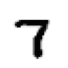

In [16]:
show_image(seven_tensors[0]);

In [17]:
seven_tensors[0].shape

torch.Size([28, 28])

Compute the pixel-wise average, by stacking the list of images to generate a rank-3 data tensor 

In [18]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [19]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

In [20]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

Here are our archetypal digits

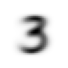

In [21]:
show_image(mean3);

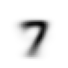

In [22]:
show_image(mean7);

Compute the mean absolute difference, and the root mean squared error between an image of a 3 and our archtypes

In [23]:
a_3 = stacked_threes[1]

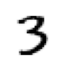

In [24]:
show_image(a_3);

In [25]:
dist_3_mad = (a_3 - mean3).abs().mean()
dist_3_rmse = ((a_3 - mean3)**2).mean().sqrt()
dist_3_mad, dist_3_rmse

(tensor(0.1114), tensor(0.2021))

In [26]:
dist_7_mad = (a_3 - mean7).abs().mean()
dist_7_rmse = ((a_3 - mean7)**2).mean().sqrt()
dist_7_mad, dist_7_rmse

(tensor(0.1586), tensor(0.3021))

We can also use the PyTorch loss functions in `torch.nn.functional`, which is imported as `F`

In [27]:
F.l1_loss(a_3, mean3), F.mse_loss(a_3, mean3).sqrt()

(tensor(0.1114), tensor(0.2021))

Create validation set

In [28]:
valid_3_tens = torch.stack([tensor(Image.open(x)) for x in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(x)) for x in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [29]:
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Create loss

In [32]:
def mean_absolute_deviation(a,b): return (a-b).abs().mean((-1,-2))

In [33]:
mean_absolute_deviation(a_3, mean3)

tensor(0.1114)

Compute loss over the whole validation set

In [35]:
valid_3_dist = mean_absolute_deviation(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1133, 0.1208, 0.1487,  ..., 0.1370, 0.1745, 0.1406]),
 torch.Size([1010]))

Notice how this function works for both a single rank-2 tensor, and the full rank-3 validation dataset. PyTorch achieves this because it is using **broadcasting**, when attempting to perform simple operations between two different tensors of different rank. This allows you to write the same operation on less code, but also has support for GPU computation.

Check:

In [36]:
mean_absolute_deviation(valid_3_tens[0,...], mean3)

tensor(0.1133)

And now we can create our simple classifier

In [37]:
def is_3(x): return mean_absolute_deviation(x, mean3) < mean_absolute_deviation(x, mean7)

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [46]:
accuracy_3s = is_3(valid_3_tens).float()
accuracy_7s = 1. - is_3(valid_7_tens).float()
accuracy = torch.cat((accuracy_3s, accuracy_7s)).mean()

In [48]:
accuracy_3s.mean(), accuracy_7s.mean(), accuracy

(tensor(0.9168), tensor(0.9854), tensor(0.9514))

So a 95% accurate model for classifying 3's and 7's can be achieved just through pixel similarity

## Aside: derivatives in PyTorch

Let's see how to calculate derivatives of functions with PyTorch. For starters, consider $y=x^2$

In [49]:
xt = tensor(3.).requires_grad_()

`_` at the end of a function is an _in-place_ operation in PyTorch. It modifies the thing to the left.

`requires_grad_` is an instruction to PyTorch that we will be wanting to compute the gradient of an operation with respect to this variable.

In [50]:
def f(x): return x**2

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

We can now compute the gradient of `yt` with respect to `xt`

In [53]:
yt.backward()

`backward` refers to back-propagation.

In [54]:
xt.grad

tensor(6.)

Which is indeed the derivative of $y=x^2|_{x=3}$

PyTorch will also broadcast derivatives for us when doing vector calculus. If we have:

$$y=x_1^2 + x_2^2 + x_3^2$$

In [55]:
xt = tensor([3.,4.,5.]).requires_grad_()

In [58]:
def f(x): return (x**2).sum()

In [59]:
yt = f(xt)
yt.backward()
xt.grad

tensor([ 6.,  8., 10.])

which is $\partial y / \partial x_i$.

## Aside: SGD in PyTorch

Make some data

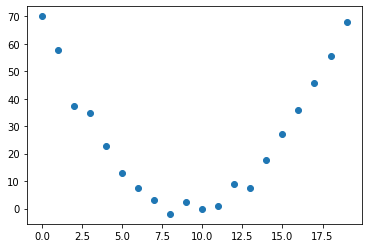

In [60]:
time = torch.arange(0,20).float()
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed);

Fit a quadratic using SGD

In [61]:
def f(t, params):
    a, b, c = params
    return a*t**2 + b*t + c

Define loss

In [62]:
def mse(pred, target): return ((pred - target)**2).mean()

In [155]:
def show_pred(pred, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(pred), color='red')
    ax.set_ylim([-300, 100])

Perform SGD

In [169]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

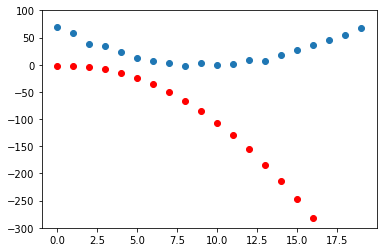

In [170]:
show_pred(f(time, orig_params))

In [171]:
lr = 1e-5
n_steps = 10

In [172]:
def apply_step(params, prn=True):
    pred = f(time, params)
    loss = mse(pred, speed)
    loss.backward()
    params.data -= lr*params.grad.data # using .data means that the gradient of this step isn't calculated
    params.grad = None
    if prn: print(loss.item())
    return pred

In [173]:
orig_params

tensor([-1.1793,  1.3110, -1.7830], grad_fn=<CloneBackward>)

In [174]:
params

tensor([-1.1793,  1.3110, -1.7830], requires_grad=True)

In [175]:
for i in range(n_steps): apply_step(params)

44157.1484375
8914.724609375
2245.774658203125
983.79931640625
744.9886474609375
699.7921142578125
691.2335205078125
689.6075439453125
689.2936401367188
689.22802734375


In [178]:
params = orig_params.detach().requires_grad_()

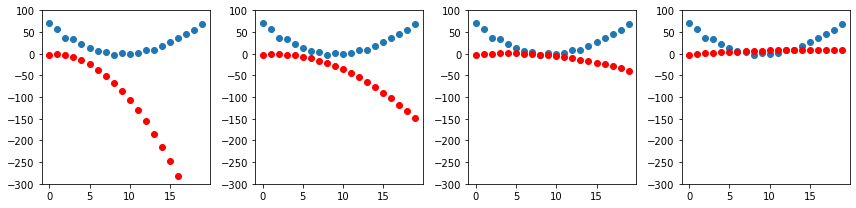

In [181]:
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## A simple linear model for MNIST

We will try to train a model of the form

```
y=sigm((w*x).sum()+b)
```

for weights `w`, data `x` and a bias `b`.

Throw away the 2D nature of the data, unravelling into 1D vectors using `view`. `-1` is a special parameter to `view` meaning "make as big as necessary to git all the data".

In [201]:
train_x = torch.cat((stacked_threes, stacked_sevens)).view(-1, 28*28)

Make `is_three` as target

In [203]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # unsqueeze adds a unit dimension so that the target is a matrix not a vector. Necessary for PyTorch

In [204]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Create a PyTorch **dataset**. When you index into a PyTorch dataset, it must return a tuple of `(x,y)`.

In [205]:
dset = list(zip(train_x, train_y))

In [206]:
x,y = dset[0]  # this is called "destructuring" a tuple
x.shape, y

(torch.Size([784]), tensor([1]))

In [210]:
valid_x = torch.cat((valid_3_tens, valid_7_tens)).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Initialize weights for all pixels

In [211]:
def init_params(size, std=1.): return (torch.randn(size)*std).requires_grad_()

In [214]:
weights = init_params((28*28,1))

In [213]:
bias = init_params(1)

So an example prediction for an image is:

In [217]:
(train_x[0]*weights.T).sum() + bias

tensor([0.7526], grad_fn=<AddBackward0>)

And a prediction for the whole dataset is:

In [238]:
def linear_model(xb): return xb@weights + bias

In [244]:
linear_model(train_x)

tensor([[ 0.7526],
        [16.7681],
        [ 9.4757],
        ...,
        [-5.9321],
        [ 5.1376],
        [ 1.8757]], grad_fn=<AddBackward0>)

Pipe the linear transformation through a sigmoid such that the predictions are between 0 and 1.

In [243]:
def mnist_model(xb): return linear_model(xb).sigmoid()

In [246]:
preds = mnist_model(train_x)
preds

tensor([[0.6798],
        [1.0000],
        [0.9999],
        ...,
        [0.0026],
        [0.9942],
        [0.8671]], grad_fn=<SigmoidBackward>)

Definte a loss function 

In [247]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

When the target is 0, return the prediction, otherwise return 1-prediction. This is like a PyTorch if statement.

We're going to use this loss, rather than e.g. accuracy, to perform SGD because the metric accuracy is very flat with respect to parameters. You have to change the parameters enough such that you differentially classify an entire image, in order for the accuracy to change. If you get 0 gradients, you will not update your parameters. **So you want loss functions which are smooth with respect to parameters.**

In contrast, `mnist_loss` has `predictions` built into it, so any change in the parameters which have an effect on `predictions` will be reflected in `mnist_loss`. 

### Putting it all together

In [248]:
weights = init_params((28*28,1))
bias = init_params(1)

In [249]:
dl = DataLoader(dset, batch_size=256)

In [250]:
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [251]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [257]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [258]:
calc_grad(xb, yb, mnist_model)

In [259]:
weights.grad.mean(), bias.grad

(tensor(-0.0082), tensor([-0.0544]))

`loss.backward()` _adds_ the gradients of `loss` to any pre-existing gradients that are stored, so we have to set the gradient to zero when we're done using the calculation from backprop.

In [265]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [266]:
calc_grad(xb, yb, mnist_model)

In [267]:
weights.grad.mean(), bias.grad

(tensor(-0.0082), tensor([-0.0544]))

In [268]:
def train_epoch(model, lr, params):
    for xb, yb in dl: # grab mini-batches
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= lr*p.grad.data
            p.grad.zero_()

In [271]:
def batch_accuracy(preds, yb):
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [272]:
batch_accuracy(mnist_model(xb), yb)

tensor(0.3633)

In [273]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [274]:
validate_epoch(mnist_model)

0.2736

Train for one epoch

In [275]:
lr = 1.
params = weights, bias
train_epoch(mnist_model, lr, params)
validate_epoch(mnist_model)

0.4957

...and do a few more

In [276]:
for i in range(20):
    train_epoch(mnist_model, lr, params)
    print(validate_epoch(mnist_model), end=' ')

0.5114 0.6077 0.7195 0.87 0.9242 0.9383 0.9515 0.9545 0.9613 0.9642 0.9667 0.9686 0.9696 0.9706 0.9711 0.9721 0.9721 0.9721 0.9721 0.9711 

Great! A linear function reaches about 97% accuracy.

## Refactor using an optimizer

PyTorch provides some useful classes to reduce the amount of boilerplate.

In [277]:
linear_model = nn.Linear(28*28, 1) # initializes randomly, with bias

In [278]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Now we create an optimizer

In [279]:
class BasicOptimizer:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad=None

In [280]:
opt = BasicOptimizer(linear_model.parameters(), lr)

In [281]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [283]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [284]:
train_model(mnist_model, 20)

0.4932 0.8183 0.8384 0.9111 0.9336 0.9472 0.9555 0.9624 0.9653 0.9668 0.9687 0.9712 0.9736 0.9751 0.976 0.9775 0.9775 0.978 0.9785 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as `BasicOptim`

In [286]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(mnist_model, 20)

0.4932 0.728 0.8579 0.9184 0.935 0.9502 0.956 0.9629 0.9663 0.9677 0.9697 0.9712 0.9741 0.9746 0.976 0.9765 0.9775 0.978 0.978 0.9785 

fastai also provides `Learner.fit` which we can use instead of `train_model`. To create a `Learner` we need to first create `DataLoaders` by passing in our training and validation `DataLoader`s:

Above, I felt it was unnatural to put the `sigmoid` into the loss function, so I put it in with the `mnist_model`. But the `Learner` class needs to be able to get a `.parameters()` method from the model. So I will put the sigmoid back into the loss function for now.

In [294]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [299]:
linear_model = nn.Linear(28*28, 1) # initializes randomly, with bias

In [300]:
dls = DataLoaders(dl, valid_dl)

In [301]:
learn = Learner(dls, linear_model, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [302]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637222,0.503347,0.495584,00:00
1,0.479331,0.214337,0.773307,00:00
2,0.177634,0.173736,0.815015,00:00
3,0.078663,0.104838,0.895976,00:00
4,0.042221,0.077194,0.923945,00:00
5,0.027994,0.062060,0.937684,00:00
6,0.022131,0.052539,0.949951,00:00
7,0.019509,0.046191,0.957311,00:00
8,0.018167,0.041740,0.960255,00:00
9,0.017352,0.038467,0.964671,00:00


## A neural network: adding a non-linearity

In [305]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.))
    res = res@w2 + b2
    return res

In [331]:
w1 = init_params((28*28,32)) # 32 activations
b1 = init_params(32)
w2 = init_params((32,1))
b2 = init_params(1)

Or, using PyTorch

In [332]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32,1),
    nn.Sigmoid() # Putting the sigmoid back into the model -- I don't get why it's getting thrown in with the loss function in this course!
)

In [333]:
def mnist_loss(predictions, targets):
    #predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

_Tip_: The ReLU can mean that you run into the zero-gradient problem again, i.e. your loss for some neurons can become insensitive to changes in parameters for some batches. This is a waste of computation -- they are called **dead units**. A trick around this is to use a leaky ReLU, so that the gradient is shallow and non-zero for negative input values. However, initialization and appropriate learning rates are the best way around this.

In [334]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [335]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.311930,0.415344,0.505397,00:00
1,0.146123,0.224475,0.809127,00:00
2,0.080510,0.112129,0.917566,00:00
3,0.052820,0.075810,0.943081,00:00
4,0.040085,0.059380,0.958292,00:00
5,0.033628,0.050190,0.964181,00:00
6,0.029937,0.044403,0.965653,00:00
7,0.027539,0.040446,0.966634,00:00
8,0.025809,0.037550,0.969087,00:00
9,0.024463,0.035325,0.972031,00:00


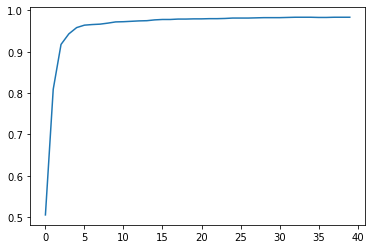

In [340]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [341]:
learn.recorder.values[-1][2]

0.983316957950592

We can inspect the parameters like this:

In [342]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
  (3): Sigmoid()
)

In [343]:
m = learn.model

We can also simply visualize the first layer's parameters (later layers require more sophisticated methods to inspect)

In [346]:
w, b = m[0].parameters()

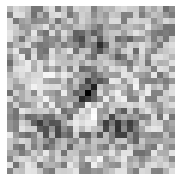

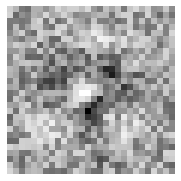

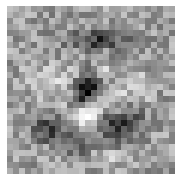

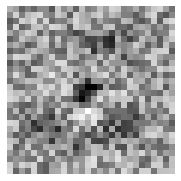

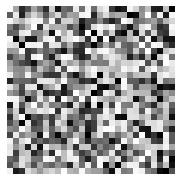

In [367]:
for i, ax in enumerate(axs): 
    show_image(w[i].view(28,28), figsize=(3,5))

So you can see that a lot of these layers are either very similar, or contain very little information. This suggests we have rather a lot more activations than we really need.

Lastly, let's compare against the full fastai factory methods

In [375]:
from fastai.vision.all import accuracy

In [377]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.159241,0.023822,0.996075,00:08


That was easy! Only 1 epoch!